# Visualizing layer outputs in the ConvDecoder

In this notebook, layer visualization is illustrated by taking the following steps: <br>
1- load an original image and fitting the decoder to it. <br>
2- turn the image into several resolutions corresponding to each layer resolution. <br>
3- fit a 1x1 convolutional layer to represent images in step 2 using the layer outputs. <br>
4- load another image and do step 2 for this image. <br>
5- do step 3 for this new image to represent its different resolutions from layer outputs corresponding to the original image. <br>

The purpose of steps 4 and 5 is to make sure that the output of layers are not capable of representing any image. <br>
You may also skip directly to [original image](#original_image) and [another_image](#another_image) to see the visualizations.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *

from PIL import Image
import PIL
import h5py
from common.evaluate import *
import pickle
from common.subsample import MaskFunc

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

# from facebook MRI
#import transforms
from include import transforms as transform
from skimage.transform import resize

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.cuda.set_device(0)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 3


# Loading the first MRI measurement

In [2]:
filename = "./singlecoil_test_images/file1000769.h5"

f = h5py.File(filename, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']
print("Kspace shape (number slices, number coils, x, y): ", f['kspace'].shape)

# which slice to consider in the following
slicenu = f["kspace"].shape[0]//2

#slice_ksp = f['kspace'][slicenu]
slice_ksp = np.array([f["kspace"][slicenu]])

slice_ksp_torchtensor = transform.to_tensor(slice_ksp)      # Convert from numpy array to pytorch tensor
slice_image = transform.ifft2(slice_ksp_torchtensor)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = transform.complex_abs(slice_image)   # Compute absolute value to get a real image

Kspace shape (number slices, number coils, x, y):  (40, 640, 368)


In [3]:
numit = 20000
LR = 0.008

In [4]:
output_depth = slice_ksp.shape[0]*2
out_size = slice_ksp.shape[1:]

num_channels = 128 #256
num_layers = 7
strides = [1]*(num_layers-1)
in_size = [10,5]
kernel_size = 3
parnet = convdecoder(out_size,in_size,output_depth,
                     num_layers,strides,num_channels, act_fun = nn.ReLU(),
                     skips=False,need_sigmoid=False,bias=True, need_last = True,
                     kernel_size=kernel_size,upsample_mode="nearest").type(dtype)
print(num_param(parnet))
parnet

[(20, 11), (40, 21), (80, 43), (160, 88), (320, 180), (640, 368)]
1035138


conv_model(
  (act_fun): ReLU()
  (net1): Sequential(
    (1): Upsample(size=(20, 11), mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Upsample(size=(40, 21), mode=nearest)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Upsample(size=(80, 43), mode=nearest)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Upsample(size=(160, 88), mode=nearest)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (17): Upsample

### scaling
Scaling the kspace to bring it in the range of the decoder output.

In [5]:
scaling_factor,ni = get_scale_factor(parnet,
                                   num_channels,
                                   in_size,
                                   slice_ksp,)

In [6]:
scaling_factor

9986.303935403395

In [7]:
slice_ksp_torchtensor = slice_ksp_torchtensor * scaling_factor
slice_ksp = slice_ksp * scaling_factor

### showing the image

In [8]:
measurement = ksp2measurement(slice_ksp).type(dtype)

(-0.5, 319.5, 319.5, -0.5)

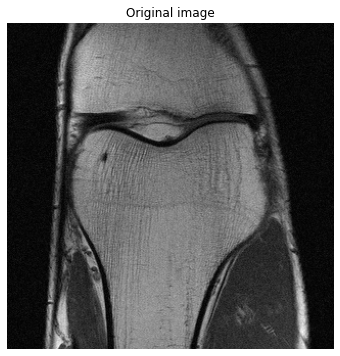

In [9]:
lsimg = lsreconstruction(measurement)
lsrss = root_sum_of_squares2(var_to_np(lsimg))
lsrec = crop_center2( lsrss , 320,320)

fig = plt.figure(figsize = (6,6)) # create a 5 x 5 figure 
ax1 = fig.add_subplot(111)
ax1.imshow(lsrec,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

### downsampling by a factor of 4

In [10]:
try: # if the file already has a mask
    temp = np.array([1 if e else 0 for e in f["mask"]])
    temp = temp[np.newaxis].T
    temp = np.array([[temp]])
    mask = transform.to_tensor(temp).type(dtype).detach().cpu()
except: # if we need to create a mask
    desired_factor = 4
    undersampling_factor = 0
    tolerance = 0.03
    while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
        mask_func = MaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
        masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
        mask1d = var_to_np(mask)[0,:,0]
        undersampling_factor = len(mask1d) / sum(mask1d)

mask1d = var_to_np(mask)[0,:,0]

# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask1d[:mask1d.shape[-1]//2-160] = 0 
mask1d[mask1d.shape[-1]//2+160:] =0
mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()

In [11]:
print(len(mask1d)/sum(mask1d))

4.433734939759036


In [12]:
masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask = mask)
unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)
sampled_image = transform.ifft2(masked_kspace)

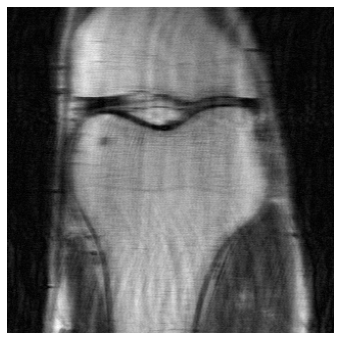

In [13]:
sampled_image_cropped = crop_center2(transform.complex_abs(sampled_image).data.cpu().numpy()[0] , 320 , 320)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(sampled_image_cropped,"gray")
ax.axis("off")
plt.show()

### fitting the ConvDecoder

In [14]:
out = []
for img in sampled_image:
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
lsest = torch.tensor(np.array([out]))

In [15]:
scale_out,sover,pover,norm_ratio,par_mse_n, par_mse_t, parni, parnet = fit( in_size = in_size,
                                                                num_channels=[num_channels]*(num_layers-1),
                                                                num_iter=numit,
                                                                LR=0.01,
                                                                mask = mask2d,
                                                                apply_f = forwardm,
                                                                img_noisy_var=unders_measurement,
                                                                net=parnet,
                                                                upsample_mode="free",
                                                                img_clean_var=Variable(lsest).type(dtype),
                                                                lsimg = lsimg,
                                                                find_best=True,
                                                                loss_type="MSE",
                                                                net_input = ni,
                                                                OPTIMIZER = "adam"
                                                                          )

input provided
optimize with adam 0.01


### Visualizing the reconstructed image

In [16]:
img = parnet(parni.type(dtype))
s = img.shape
ns = int(s[1]/2) # number of slices
fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
for i in range(ns):
    fimg[0,i,:,:,0] = img[0,2*i,:,:]
    fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
Fimg = transform.fft2(fimg) # dim: (1,num_slices,x,y,2)
# ksp has dim: (num_slices,x,y)
meas = ksp2measurement(slice_ksp) # dim: (1,num_slices,x,y,2)
mask = torch.from_numpy(np.array(mask1d, dtype=np.uint8))
ksp_dc = Fimg.clone()
ksp_dc = ksp_dc.detach().cpu()
ksp_dc[:,:,:,mask==1,:] = meas[:,:,:,mask==1,:] # after data consistency block

img_dc = transform.ifft2(ksp_dc)[0]
out = []
for img in img_dc.detach().cpu():
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]

par_out_chs = np.array(out)
#par_out_chs = parnet( parni.type(dtype),scale_out=scale_out ).data.cpu().numpy()[0]
par_out_imgs = channels2imgs(par_out_chs)

prec = crop_center2(root_sum_of_squares2(par_out_imgs),320,320)

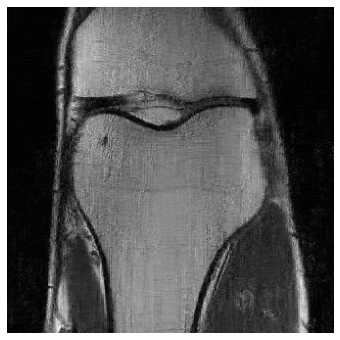

In [17]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(prec,"gray")
ax.axis("off")
plt.show()

### Collect intermediate layer outputs for visualization

In [42]:
inds = np.array(range(1,num_layers))*4 # 5 comes from the number of blocks per layer
intermeds = []
for i in inds:
    intermeds.append(parnet.net1[:i](parni.type(dtype)))
    print(intermeds[-1].shape)

torch.Size([1, 128, 20, 11])
torch.Size([1, 128, 40, 21])
torch.Size([1, 128, 80, 43])
torch.Size([1, 128, 160, 88])
torch.Size([1, 128, 320, 180])
torch.Size([1, 128, 640, 368])


Now, we turn the original image into different images of various resolutions (same as the resolutions associated with each layer)

In [43]:
temp = transform.ifft2(slice_ksp_torchtensor)
comp = []
for img in temp:
    comp += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
comp = torch.tensor(np.array([comp]))
comp.shape

torch.Size([1, 2, 640, 368])

In [44]:
sizes = [intrmd.shape[-2:] for intrmd in intermeds]
ms_orig = [] # multi-scale orig
for i,s in enumerate(sizes):
    temp = []
    for im in comp[0].data.cpu().numpy():
        temp.append(resize(im,s,anti_aliasing=True))
    ms_orig.append( torch.tensor([temp]).type(dtype) )
ms_orig[0].shape

torch.Size([1, 2, 20, 11])

### Fit a 1-layer 1x1 convolutional layer to the output of each layer

In [45]:
import torch.nn as nn
class my_1x1(nn.Module):
    def __init__(self,num_channels,num_out_channels,bias):
        super(my_1x1, self).__init__()
        self.net = nn.Sequential()
        self.net.add(nn.Conv2d(num_channels, num_out_channels, 1, 1, padding=0, bias=bias))
    def forward(self,x):
        return self.net(x)

In [46]:
extracted_images = []
for inp,o in zip(intermeds,ms_orig):
    #o = torch.rand(o.shape).type(dtype)
    block = my_1x1(num_channels,output_depth,True).type(dtype)
    _,_,_,_,_,_, _, block=fit( in_size =  (1,1), # irrelevant, just put something here
                    num_channels=[num_channels]*(num_layers-1),
                    num_iter=1000,
                    LR=0.001,
                    img_noisy_var=o,#np_to_var(np.array([o])).type(dtype),
                    net=block,
                    upsample_mode="free",
                    img_clean_var=o,#np_to_var(np.array([o])).type(dtype),
                    find_best=True,
                    loss_type="MSE",
                    net_input = inp,
                    OPTIMIZER = "adam",
                    retain_graph = True,
                              )
    extracted_images.append( root_sum_of_squares2(channels2imgs(block( inp.type(dtype) ).data.cpu().numpy()[0])) )
    print("\n",extracted_images[-1].shape,"\n")
    del(block)

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.038335  Actual loss 0.038335 Actual loss orig 0.038335 
 (20, 11) 

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.028770  Actual loss 0.028770 Actual loss orig 0.028770 
 (40, 21) 

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.032643  Actual loss 0.032643 Actual loss orig 0.032643 60 
 (80, 43) 

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.046609  Actual loss 0.046609 Actual loss orig 0.046609 84 
 (160, 88) 

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.040578  Actual loss 0.040578 Actual loss orig 0.040578 59 
 (320, 180) 

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.037992  Actual loss 0.037992 Actual loss orig 0.037992 
 (640, 368) 



<a id='original_image'></a>
### original image

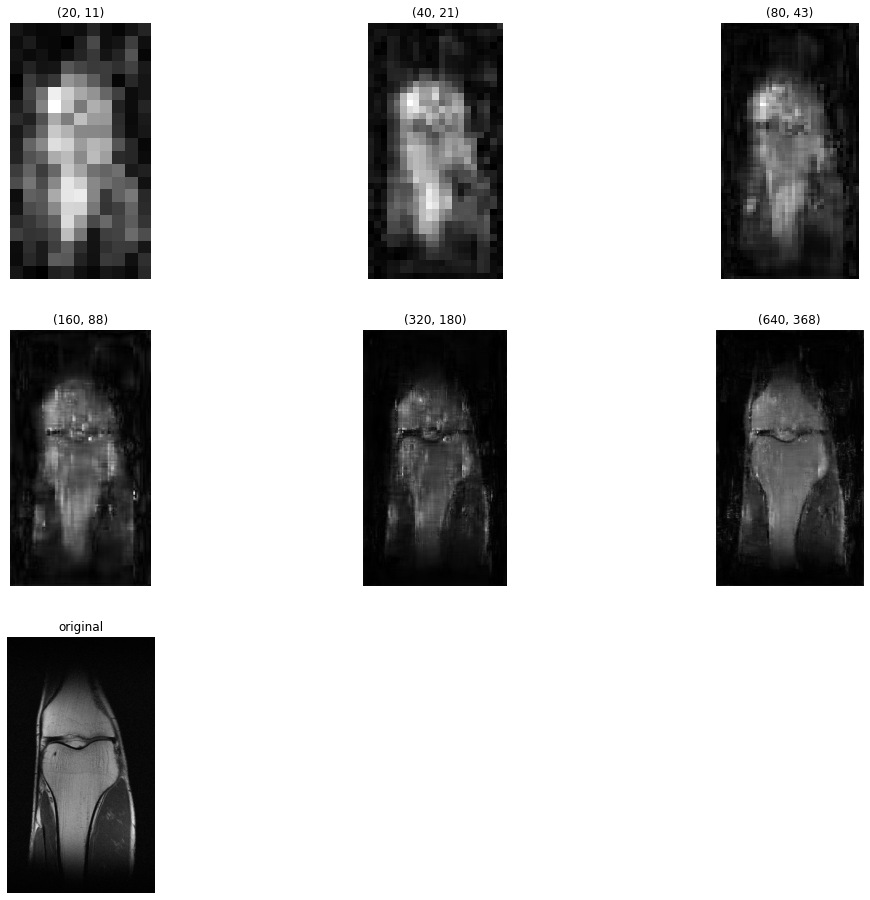

In [47]:
fig = plt.figure(figsize=(18,16))
for i,img in enumerate(extracted_images):
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img,"gray")
    ax.set_title(img.shape)
    ax.axis("off")
ax = fig.add_subplot(3,3,i+2)
ax.imshow(lsrss,"gray")
ax.set_title("original")
ax.axis("off")
plt.show()

### Load a new image
Pick a different MRI image from the original one, since it helps better seeing the visualization difference.

In [48]:
filename2 = "./singlecoil_test_images/file1001893.h5"

f2 = h5py.File(filename2, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']
print("Kspace shape (number slices, number coils, x, y): ", f['kspace'].shape)

# which slice to consider in the following
slicenu2 = f2["kspace"].shape[0]//2

#slice_ksp = f['kspace'][slicenu]
slice_ksp2 = np.array([f2["kspace"][slicenu2]])

slice_ksp_torchtensor2 = transform.to_tensor(slice_ksp2)      # Convert from numpy array to pytorch tensor
slice_image2 = transform.ifft2(slice_ksp_torchtensor2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs2 = transform.complex_abs(slice_image2)   # Compute absolute value to get a real image

Kspace shape (number slices, number coils, x, y):  (40, 640, 368)


### scaling
Scaling the kspace to bring it in the range of the decoder output.

In [49]:
scaling_factor2,_ = get_scale_factor(parnet,
                                   num_channels,
                                   in_size,
                                   slice_ksp2,)

In [50]:
scaling_factor2

5728.543506216936

In [51]:
slice_ksp_torchtensor2 = slice_ksp_torchtensor2 * scaling_factor2
slice_ksp = slice_ksp2 * scaling_factor2

### showing the image

In [52]:
measurement2 = ksp2measurement(slice_ksp2).type(dtype)

(-0.5, 319.5, 319.5, -0.5)

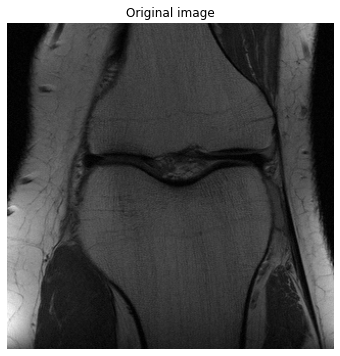

In [53]:
lsimg2 = lsreconstruction(measurement2)
lsrss2 = root_sum_of_squares2(var_to_np(lsimg2))
lsrec2 = crop_center2( lsrss2 , 320,320)

fig = plt.figure(figsize = (6,6)) # create a 5 x 5 figure 
ax1 = fig.add_subplot(111)
ax1.imshow(lsrec2,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

Now, we turn this image into different images of various resolutions (same as the resolutions associated with each layer)

In [54]:
temp = transform.ifft2(slice_ksp_torchtensor2)
comp2 = []
for img in temp:
    comp2 += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
comp2 = torch.tensor(np.array([comp2]))
comp2.shape

torch.Size([1, 2, 640, 368])

In [55]:
sizes = [intrmd.shape[-2:] for intrmd in intermeds]
ms_orig2 = [] # multi-scale orig
for i,s in enumerate(sizes):
    temp = []
    for im in comp2[0].data.cpu().numpy():
        temp.append(resize(im,s,anti_aliasing=True))
    ms_orig2.append( torch.tensor([temp]).type(dtype) )
ms_orig2[0].shape

torch.Size([1, 2, 20, 11])

### Fit a 1-layer 1x1 convolutional layer to the output of each layer for this new image

In [56]:
extracted_images2 = []
for inp,o in zip(intermeds,ms_orig2):
    #o = torch.rand(o.shape).type(dtype)
    block = my_1x1(num_channels,output_depth,True).type(dtype)
    _,_,_,_,_,_, _, block=fit( in_size =  (1,1), # irrelevant, just put something here
                    num_channels=[num_channels]*(num_layers-1),
                    num_iter=1000,
                    LR=0.001,
                    img_noisy_var=o,#np_to_var(np.array([o])).type(dtype),
                    net=block,
                    upsample_mode="free",
                    img_clean_var=o,#np_to_var(np.array([o])).type(dtype),
                    find_best=True,
                    loss_type="MSE",
                    net_input = inp,
                    OPTIMIZER = "adam",
                    retain_graph = True,
                              )
    extracted_images2.append( root_sum_of_squares2(channels2imgs(block( inp.type(dtype) ).data.cpu().numpy()[0])) )
    print("\n",extracted_images2[-1].shape,"\n")
    del(block)

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.051281  Actual loss 0.051281 Actual loss orig 0.051281 
 (20, 11) 

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.066160  Actual loss 0.066160 Actual loss orig 0.066160 
 (40, 21) 

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.088230  Actual loss 0.088230 Actual loss orig 0.088230 74 
 (80, 43) 

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.129623  Actual loss 0.129623 Actual loss orig 0.129623 38 
 (160, 88) 

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.147439  Actual loss 0.147439 Actual loss orig 0.147439 72 
 (320, 180) 

input provided
optimize with adam 0.001
Iteration 00900    Train loss 0.146138  Actual loss 0.146138 Actual loss orig 0.146138 
 (640, 368) 



<a id='another_image'></a>
### another image

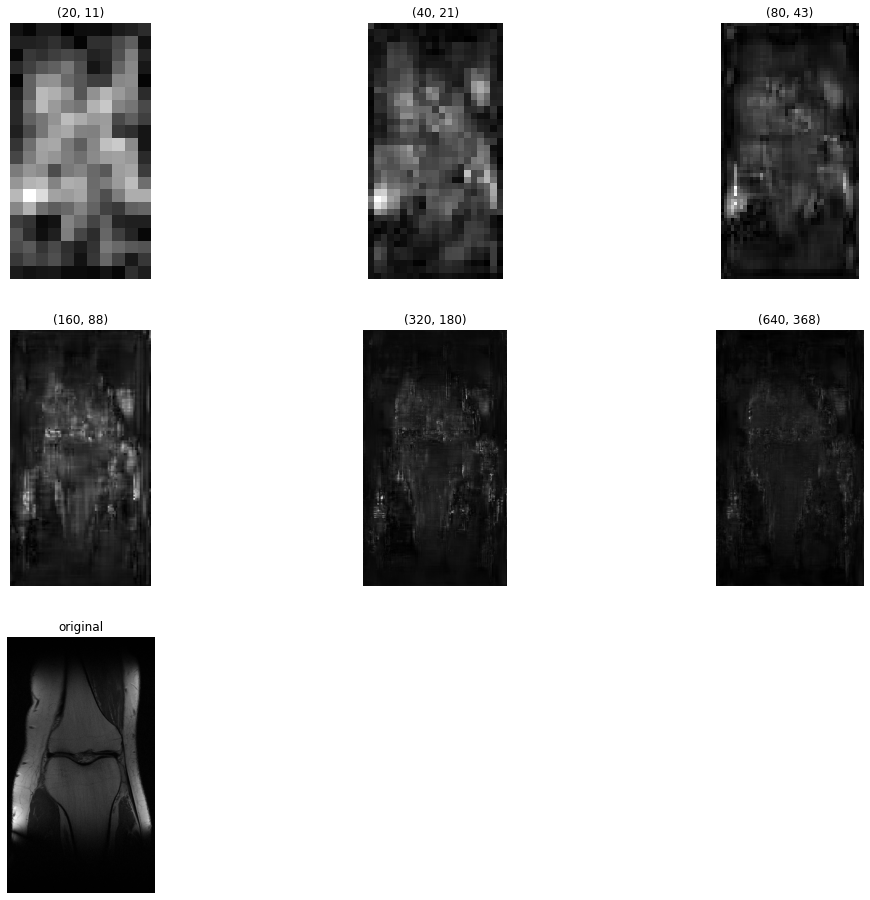

In [57]:
fig = plt.figure(figsize=(18,16))
for i,img in enumerate(extracted_images2):
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img,"gray")
    ax.set_title(img.shape)
    ax.axis("off")
ax = fig.add_subplot(3,3,i+2)
ax.imshow(lsrss2,"gray")
ax.set_title("original")
ax.axis("off")
plt.show()

As you can see, the representations can only be mapped to the original image to which the network was fitted. This shows the network is reconstructing the image it's trying to fit scale by scale after each layer.